In [1]:
import numpy as np
import csv
import re
import os
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize
from nipy import load_image, save_image
from nipy.core.api import Image
import pymc3 as pm
import theano.tensor as T
import pandas as pd
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator


In [2]:
def getData(src):
    pdata = pd.read_csv(src)
    pdata['id'] = pdata['StudyID'].map(str) + '_' + pdata['MR_num'].map(str) + '_' + pdata['Scan_num'].map(str)
    #place_holder for future, won't currently delete anything probably
    pdata = pdata.drop_duplicates(subset='id')  
    pdata.head()
    
    #To make plot labels fit better
    pdata.columns = pdata.columns.str.replace(r"Cingulum_Parahippocampal", "CNGLM_PRHP")
    pdata.columns = pdata.columns.str.replace(r"Corpus_Callosum_Body", "CCBody")
    pdata.columns = pdata.columns.str.replace(r"Corticospinal_Tract", "CST")
    pdata.columns = pdata.columns.str.replace(r"Inferior_Fronto_Occipital_Fasciculus", "IFOF")
    pdata.columns = pdata.columns.str.replace(r"Inferior_Longitudinal_Fasciculus", "IFL")
    return pdata

In [3]:
def getVols(pdata):
    #filter only tract volumes
    tract_volumes = re.compile(r'[.]volume\(mm\^3\)$')
    filtered = list(filter(tract_volumes.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_vol = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='Volume') 
    df_vol['Tract'] = df_vol['Tract'].str.strip('.volume(mm^3)')
    df_vol = df_vol.dropna()
    df_vol.head()
    return df_vol

In [4]:
def getMeanLengths(pdata):
    #filter only tract length 
    tract_lens = re.compile(r'[.]mean_length\(mm\)$')
    filtered = list(filter(tract_lens.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_len = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='Length') 
    df_len['Tract'] = df_len['Tract'].str.strip('.mean_length(mm)')
    df_len = df_len.dropna()
    df_len.head()
    return df_len

In [5]:
def getFA(pdata):
    #filter only tract FA 
    tract_fa= re.compile(r'[.]fa$')
    filtered = list(filter(tract_fa.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_fa = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='FA') 
    df_fa['Tract'] = df_fa['Tract'].str.strip('.fa')
    df_fa = df_fa.dropna()
    df_fa.head()
    return df_fa 

In [11]:
pdata = getData('/data/Reback-DTI/resources/stats/Eddy_corrected/Batch3/Output_dir/strats/all_ages/all_ages.csv')
getFA(pdata)

,id,pcpcgp_6mo,Tract,FA
0,2_MR1_9,1.0,Cingulum_Frontal_Parahippocampal_L,0.328716
1,4_MR1_10,1.0,Cingulum_Frontal_Parahippocampal_L,0.252708
2,5_MR1_6,1.0,Cingulum_Frontal_Parahippocampal_L,0.200291
3,10_MR5_5,0.0,Cingulum_Frontal_Parahippocampal_L,0.135430
4,15_MR1_7,1.0,Cingulum_Frontal_Parahippocampal_L,0.266148
...,...,...,...,...
394,1502_MR1_6,1.0,whole_brain,0.282056
395,1504_MR1_6,1.0,whole_brain,0.188195
396,1601_MR1_5,0.0,whole_brain,0.303075
397,1701_MR1_5,1.0,whole_brain,0.236432


In [6]:
def getRD(pdata):
    #filter only tract RD 
    tract_rd = re.compile(r'[.]rd$')
    filtered = list(filter(tract_rd.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_rd = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='RD') 
    df_rd['Tract'] = df_rd['Tract'].str.strip('.rd')
    df_rd = df_rd.dropna()
    df_rd.head()
    return df_rd

In [7]:
def getMD(pdata):
    #filter only tract MD 
    tract_md = re.compile(r'[.]md$')
    filtered = list(filter(tract_md.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_md = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='MD') 
    df_md['Tract'] = df_md['Tract'].str.strip('.md')
    df_md = df_md.dropna()
    df_md.head()
    return df_md

In [8]:
def plotViolins(src, save_dir, df_fa, df_rd, df_md, df_vol, df_len):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(16, 16))

    plt.subplot(511) 
    ax1 = sns.violinplot(x='Tract', y='FA', data=df_fa, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(512) 
    ax1 = sns.violinplot(x='Tract', y='RD', data=df_rd, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(513) 
    ax1 = sns.violinplot(x='Tract', y='MD', data=df_md, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(514) 
    ax1 = sns.violinplot(x='Tract', y='Volume', data=df_vol, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(515) 
    ax1 = sns.violinplot(x='Tract', y='Length', data=df_len, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    figure_name = 'violins' + '_' + outcome
    figure_ext = '.png'
    plt.savefig(os.path.join(save_dir + figure_name + figure_ext))

Note to Joy: 

Below is used to graph the covariates. Currently commented out because I don't need it running all the time. Especially when I 'Run All' cells

In [9]:
def getAges(pdata):
    #filter only tract volumes
    tract_ages = re.compile(r'[.]Age_y')
    filtered = list(filter(tract_ages.search, pdata.columns))
    #print(filtered)
    pdata1 = pdata
    pdata1["All"] = 'All'
    df_age = pdata1[['id','Age_y','All',outcome]]
    df_age = df_age.dropna()
    df_age.head()
    return df_age

In [10]:
def getSexes(pdata):
    #filter only tract volumes
    tract_sex = re.compile(r'[.]Sex')
    filtered = list(filter(tract_sex.search, pdata.columns))
    #print(filtered)
    pdata1 = pdata
    pdata1["All"] = 'All'
    df_sex = pdata1[['id','Sex','All',outcome]]
    df_sex = df_sex.dropna()
    df_sex.head()
    return df_sex

In [11]:
def plotCovariates(src, save_dir, df_age, df_sex):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(9, 9))

    plt.subplot(311) 
    ax1 = sns.violinplot(x='All', y='Age_y', data=df_age, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(312) 
    ax1 = sns.barplot(x='All', y='Sex', data=df_sex, hue=outcome)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(313) 
    ax1 = sns.countplot(x=outcome, data=df_age)

    figure_name = 'violins' + '_' + outcome + '_' + 'covariates'
    figure_ext = '.png'
    plt.savefig(save_dir + figure_name + figure_ext)

Note to Joy:

Below is used to compute and graph the assymetry. 

In [12]:
def calculateAsym(pdata):
    #Calculate the asymmetries
    #Note: metrics are written the same as it is in the csv and the tract names are from the above substitutions made
    metrics = ['ad', 'md', 'fa', 'rd', 'mean_length(mm)', 'span(mm)', 'volume(mm^3)', 'number_of_tracts']
    bilateral_tracts = ['CNGLM_PRHP', 'CST', 'IFOF', 'IFL']
    for btract in bilateral_tracts:
        for metric in metrics:
            pdata[f'{btract}_asym.{metric}'] = abs(pdata[f'{btract}_L.{metric}'] - pdata[f'{btract}_R.{metric}']) 
    pdata.sample()
    return pdata

In [13]:
def getVolAsym(pdata):
    #filter only tract volumes asymmetries
    tract_volumes_asym = re.compile(r'_asym[.]volume\(mm\^3\)$')
    filtered = list(filter(tract_volumes_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_vol_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInVolume') 
    df_vol_asym['Tract'] = df_vol_asym['Tract'].str.strip('_asym.volume(mm^3)')
    df_vol_asym = df_vol_asym.dropna()
    df_vol_asym.head()
    return df_vol_asym

In [14]:
def getLenAsym(pdata):
    #filter only tract length asymmetries
    tract_lens_asym = re.compile(r'_asym[.]mean_length\(mm\)$')
    filtered = list(filter(tract_lens_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_len_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInLength') 
    df_len_asym['Tract'] = df_len_asym['Tract'].str.strip('_asym.mean_length(mm)')
    df_len_asym = df_len_asym.dropna()
    df_len_asym.head()
    return df_len_asym

In [15]:
def getSpanAsym(pdata):
    #filter only tract span asymmetries
    tract_span_asym = re.compile(r'_asym[.]span\(mm\)$')
    filtered = list(filter(tract_span_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_span_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInSpan') 
    df_span_asym['Tract'] = df_span_asym['Tract'].str.strip('_asym.span(mm)')
    df_span_asym = df_span_asym.dropna()
    df_span_asym.head()
    return df_span_asym

In [16]:
def getNumTractsAsym(pdata):
    #filter only tract number asymmetries
    tract_numTracts_asym = re.compile(r'_asym[.]number_of_tracts$')
    filtered = list(filter(tract_numTracts_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_numTracts_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInNumTracts') 
    df_numTracts_asym['Tract'] = df_numTracts_asym['Tract'].str.strip('_asym.number_of_tracts')
    df_numTracts_asym = df_numTracts_asym.dropna()
    df_numTracts_asym.head()
    return df_numTracts_asym

In [17]:
def getFAAsym(pdata):
    #filter only tract FA asymmetries
    tract_fa_asym= re.compile(r'_asym[.]fa$')
    filtered = list(filter(tract_fa_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_fa_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInFA') 
    df_fa_asym['Tract'] = df_fa_asym['Tract'].str.strip('_asym.fa')
    df_fa_asym = df_fa_asym.dropna()
    df_fa_asym.head()
    return df_fa_asym

In [18]:
def getMDAsym(pdata):
    #filter only tract MD asymmetries
    tract_md_asym= re.compile(r'_asym[.]md$')
    filtered = list(filter(tract_md_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_md_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInMD') 
    df_md_asym['Tract'] = df_md_asym['Tract'].str.strip('_asym.md')
    df_md_asym = df_md_asym.dropna()
    df_md_asym.head()
    return df_md_asym

In [19]:
def getRDAsym(pdata):
    #filter only tract RD asymmetries 
    tract_rd_asym= re.compile(r'_asym[.]rd$')
    filtered = list(filter(tract_rd_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_rd_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInRD') 
    df_rd_asym['Tract'] = df_rd_asym['Tract'].str.strip('_asym.rd')
    df_rd_asym = df_rd_asym.dropna()
    df_rd_asym.head()
    return df_rd_asym
 

In [20]:
def getADAsym(pdata):
    #filter only tract AD asymmetries
    tract_ad_asym= re.compile(r'_asym[.]ad$')
    filtered = list(filter(tract_ad_asym.search, pdata.columns))
    #print(filtered)

    ### USE MELT TO CONVERT FROM WIDE TO LONG FORM
    df_ad_asym = pd.melt(pdata, id_vars=['id', outcome], value_vars=filtered, var_name='Tract', value_name='DiffInAD') 
    df_ad_asym['Tract'] = df_ad_asym['Tract'].str.strip('_asym.ad')
    df_ad_asym = df_ad_asym.dropna()
    df_ad_asym.head()
    return df_ad_asym

In [21]:
def plotAsyms(src, save_dir, df_fa_asym, df_rd_asym, df_md_asym, df_vol_asym, df_len_asym, df_span_asym, df_numTracts_asym): 
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20, 20))

    plt.subplot(711) 
    ax1 = sns.violinplot(x='Tract', y='DiffInFA', data=df_fa_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(712) 
    ax1 = sns.violinplot(x='Tract', y='DiffInRD', data=df_rd_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(713) 
    ax1 = sns.violinplot(x='Tract', y='DiffInMD', data=df_md_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(714) 
    ax1 = sns.violinplot(x='Tract', y='DiffInVolume', data=df_vol_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(715) 
    ax1 = sns.violinplot(x='Tract', y='DiffInLength', data=df_len_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(716) 
    ax1 = sns.violinplot(x='Tract', y='DiffInSpan', data=df_span_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    plt.subplot(717) 
    ax1 = sns.violinplot(x='Tract', y='DiffInNumTracts', data=df_numTracts_asym, hue=outcome, split=True)
    ax1.minorticks_on()
    ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax1.grid(which='minor', axis='x', linewidth=1)

    figure_name = 'violins_' + outcome + '_asym'
    figure_ext = '.png'
    plt.savefig(os.path.join(save_dir + figure_name + figure_ext))

In [22]:
def runAnalysis(src, save_dir): 
    pdata = getData(src) 
    
    df_fa  = getFA(pdata)
    df_rd  = getRD(pdata)
    df_md  = getMD(pdata)
    df_vol = getVols(pdata)
    df_len = getMeanLengths(pdata)
    plotViolins(src, save_dir, df_fa, df_rd, df_md, df_vol, df_len)
    
    
    df_age = getAges(pdata)
    df_sex = getSexes(pdata)
    plotCovariates(src, save_dir, df_age, df_sex)
    
    
    calculateAsym(pdata)
    df_fa_asym        = getFAAsym(pdata)
    df_rd_asym        = getRDAsym(pdata)
    df_md_asym        = getMDAsym(pdata)
    df_vol_asym       = getVolAsym(pdata)
    df_len_asym       = getLenAsym(pdata)
    df_span_asym      = getSpanAsym(pdata)
    df_numTracts_asym = getNumTractsAsym(pdata)
    plotAsyms(src, save_dir, df_fa_asym, df_rd_asym, df_md_asym, df_vol_asym, df_len_asym, df_span_asym, df_numTracts_asym) 
    

In [7]:
base_dir = '/data/Reback-DTI/resources/'
strat_dir = os.path.join(base_dir, 'strats','Eddy_corrected', 'nonadjusted')

all_ages_dir = os.path.join(strat_dir, 'all_ages/')
all_ages_src = os.path.join(all_ages_dir, 'all_ages.csv')
age0_1_dir  = os.path.join(strat_dir, 'ages0_1/')
age1_5_dir  = os.path.join(strat_dir, 'ages1_5/')
age5__dir   = os.path.join(strat_dir, 'ages5_/')
age1__dir   = os.path.join(strat_dir, 'ages1_/')
age0_5_dir   = os.path.join(strat_dir, 'ages0_5/')
age0_1_src  = os.path.join(age0_1_dir, 'ages0_1.csv')
age1_5_src  = os.path.join(age1_5_dir, 'ages1_5.csv')
age5__src   = os.path.join(age5__dir,   'ages5_.csv')
age1__src   = os.path.join(age1__dir,   'ages1_.csv')
age0_5_src   = os.path.join(age0_5_dir,   'ages0_5.csv')
outcomes = ['pcpcgp_6mo', 'mortality_6mos']

In [8]:
outcome = outcomes[0]

In [9]:
pdata = getData(all_ages_src) 
df_fa = getFA(pdata)
df_fa.head()

FileNotFoundError: [Errno 2] No such file or directory: '/data/Reback-DTI/resources/strats/Eddy_corrected/nonadjusted/all_ages/all_ages.csv'

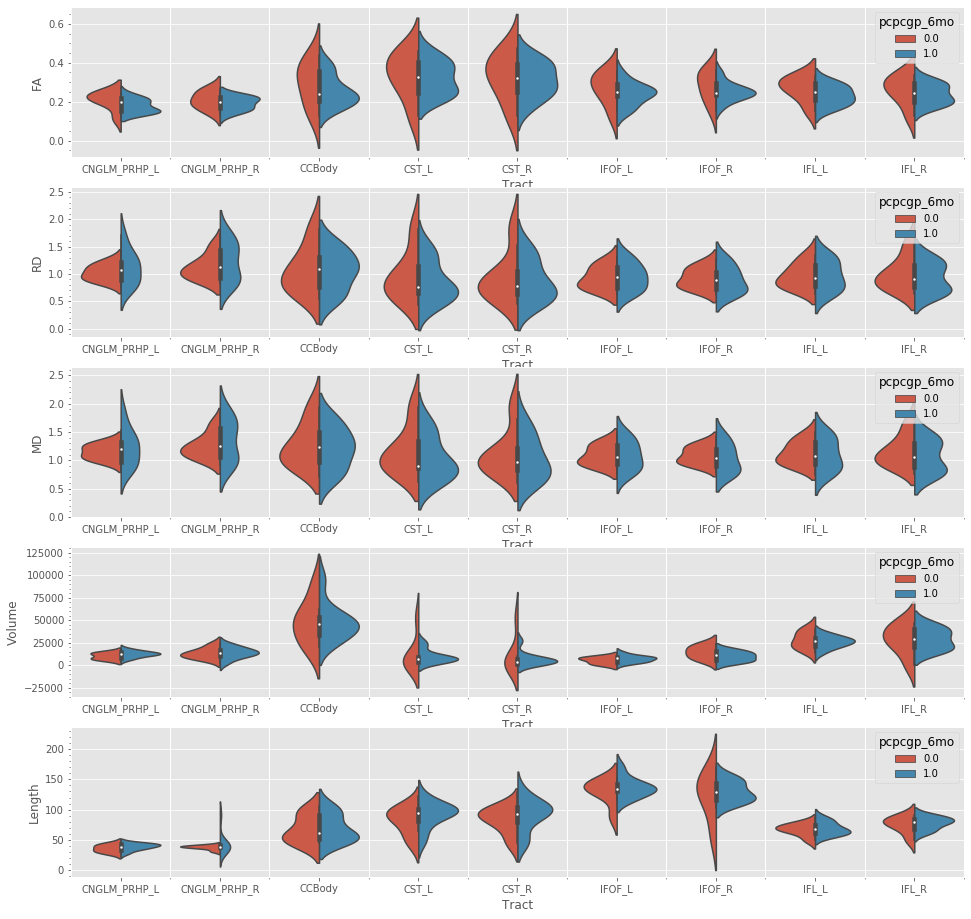

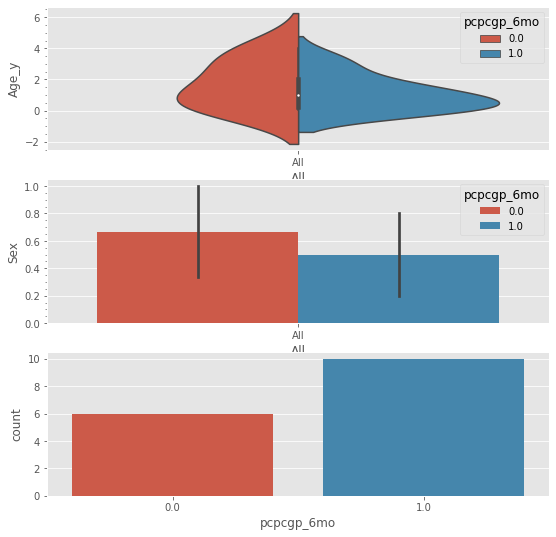

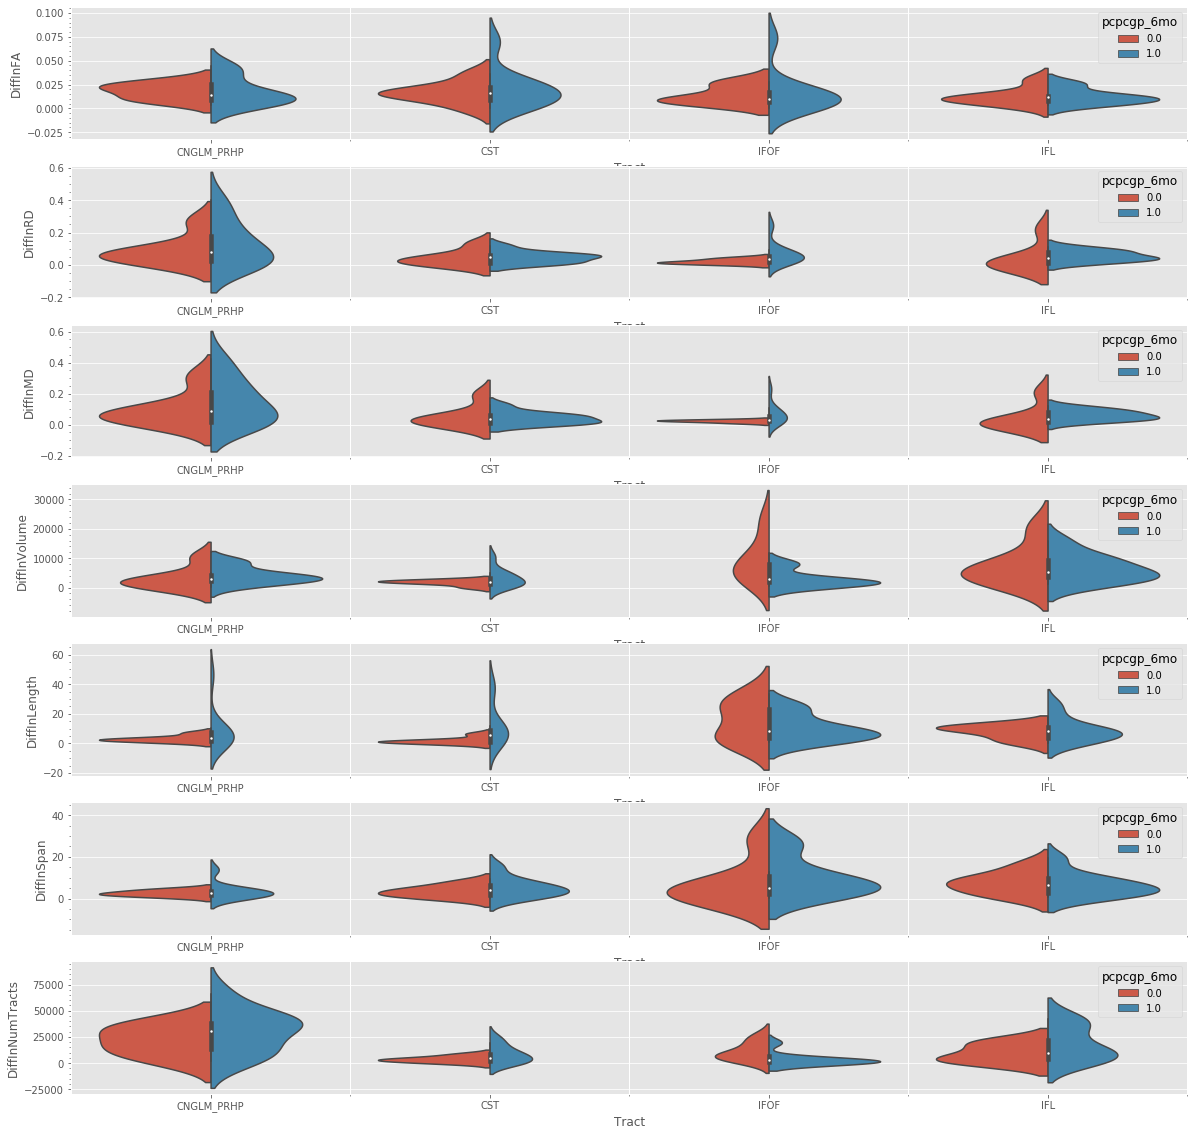

In [37]:
runAnalysis(age0_5_src, age0_5_dir)

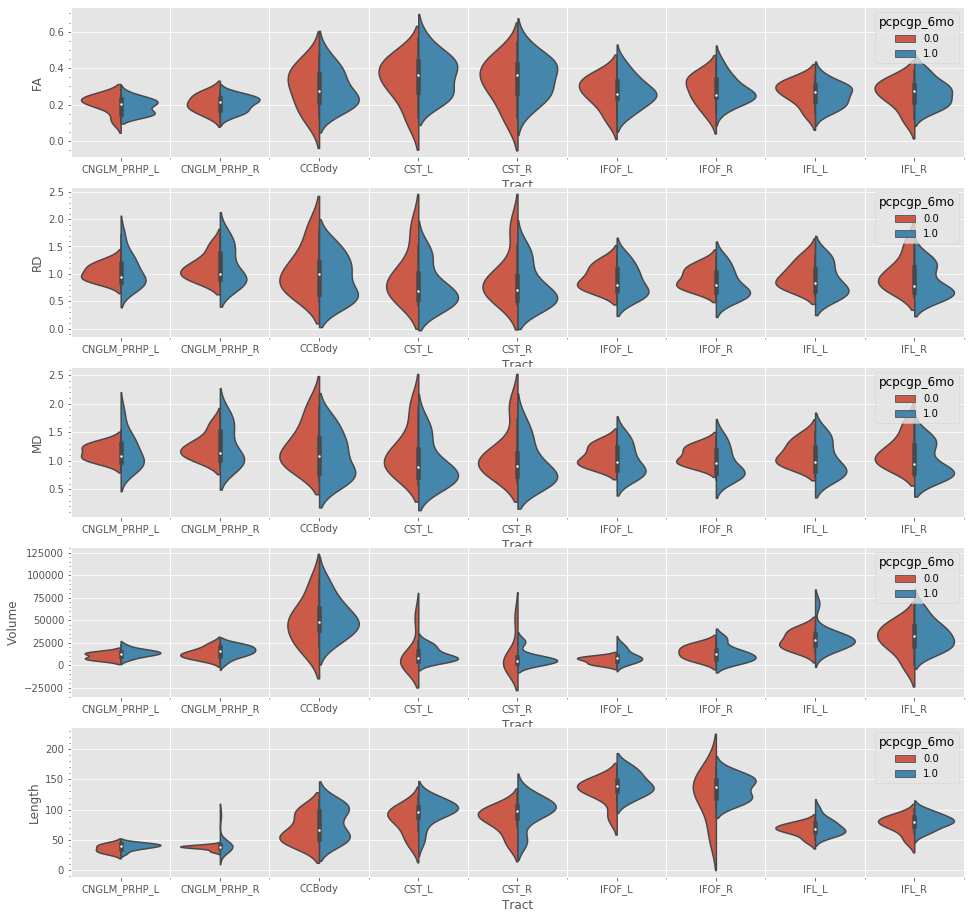

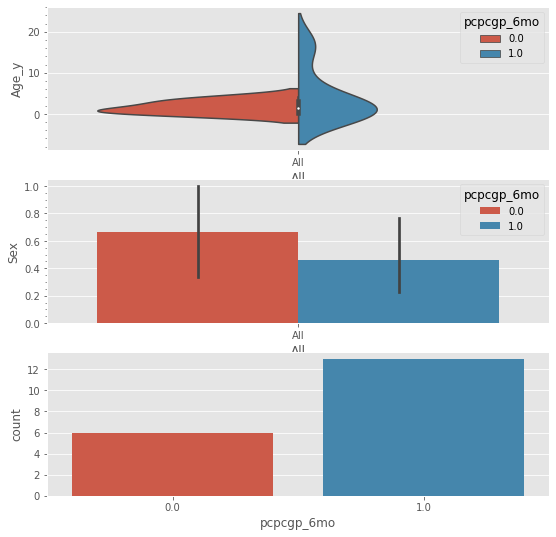

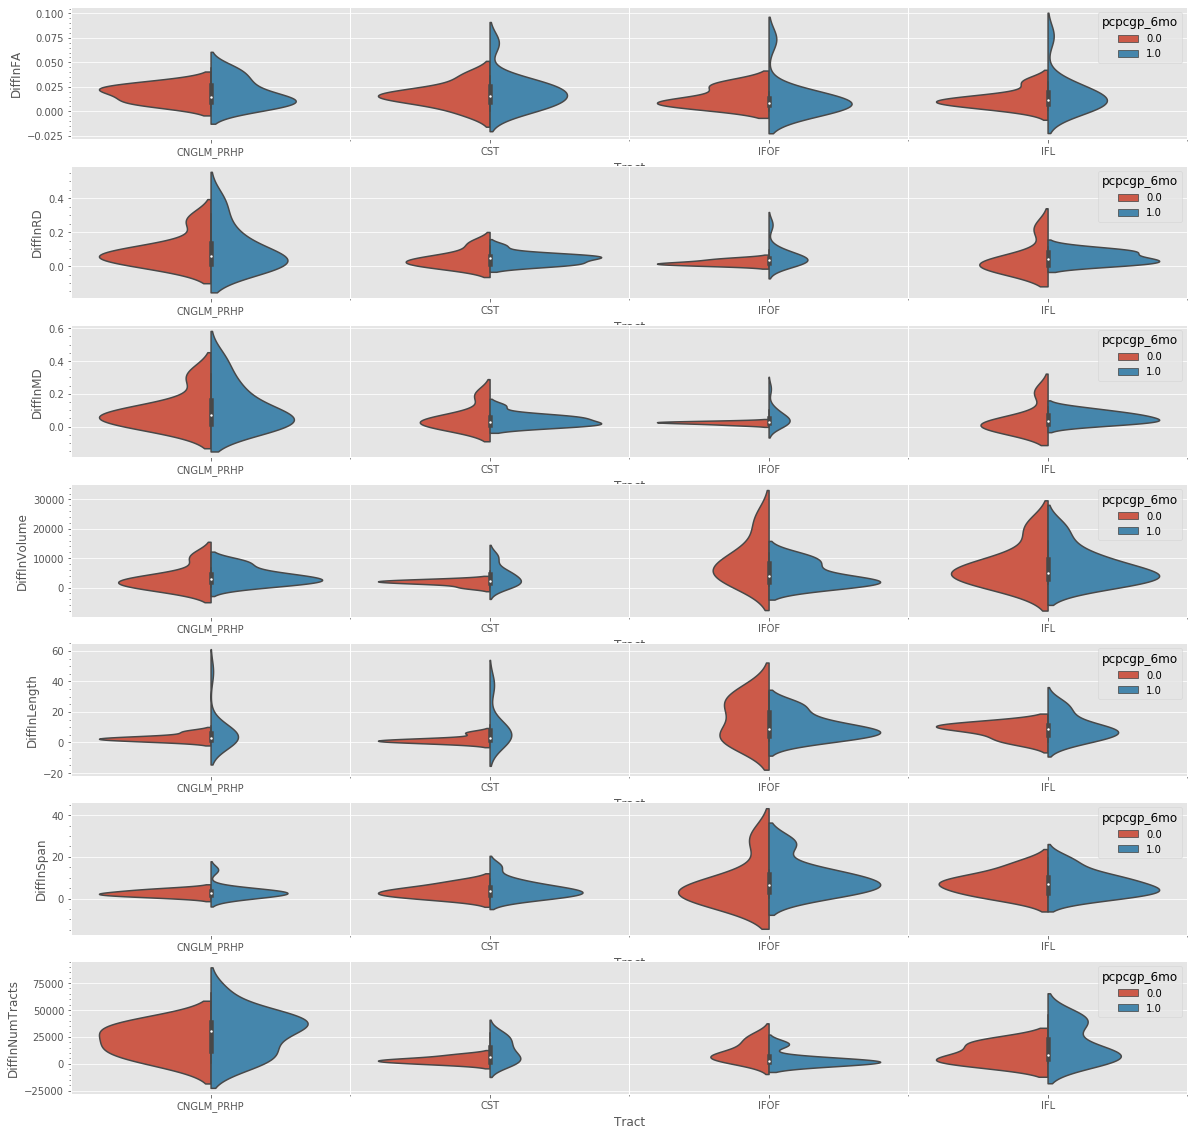

In [38]:
runAnalysis(all_ages_src, all_ages_dir)

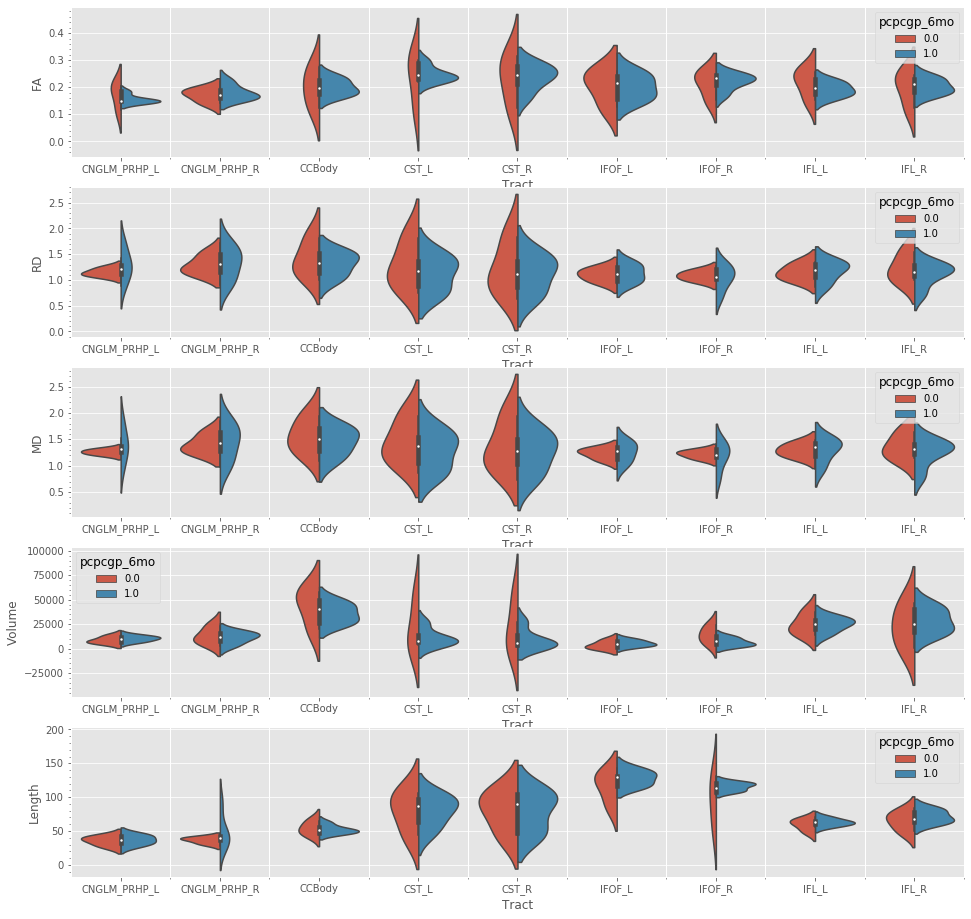

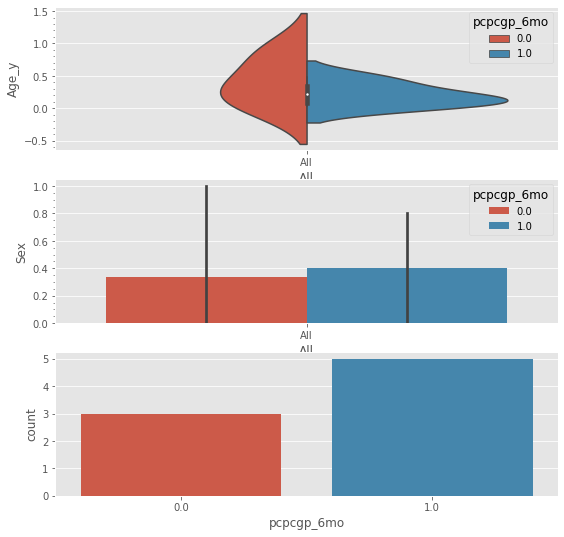

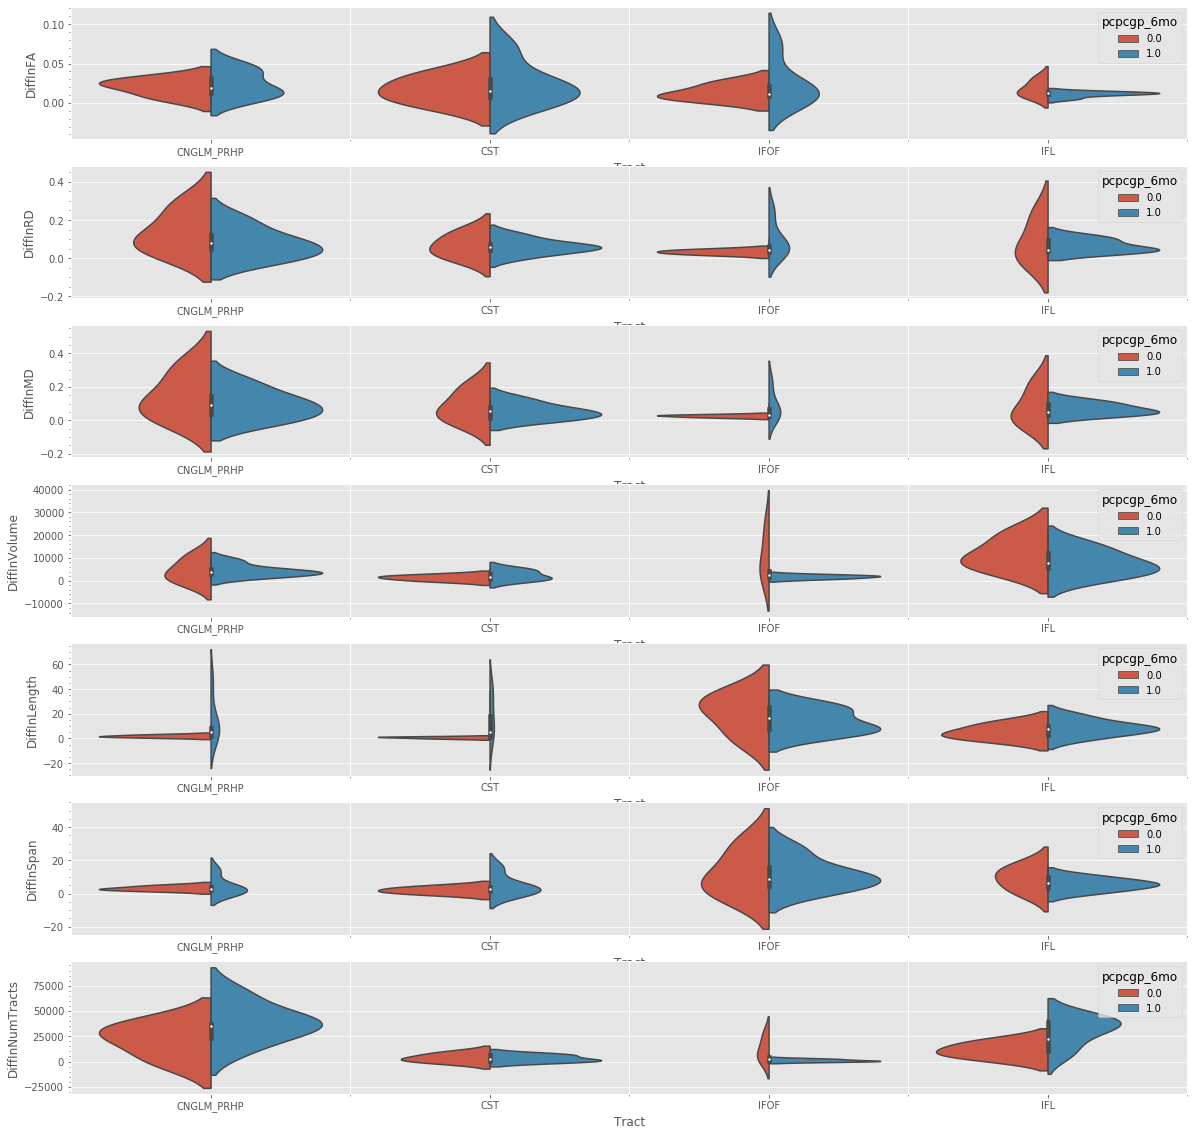

In [39]:
runAnalysis(age0_1_src, age0_1_dir)

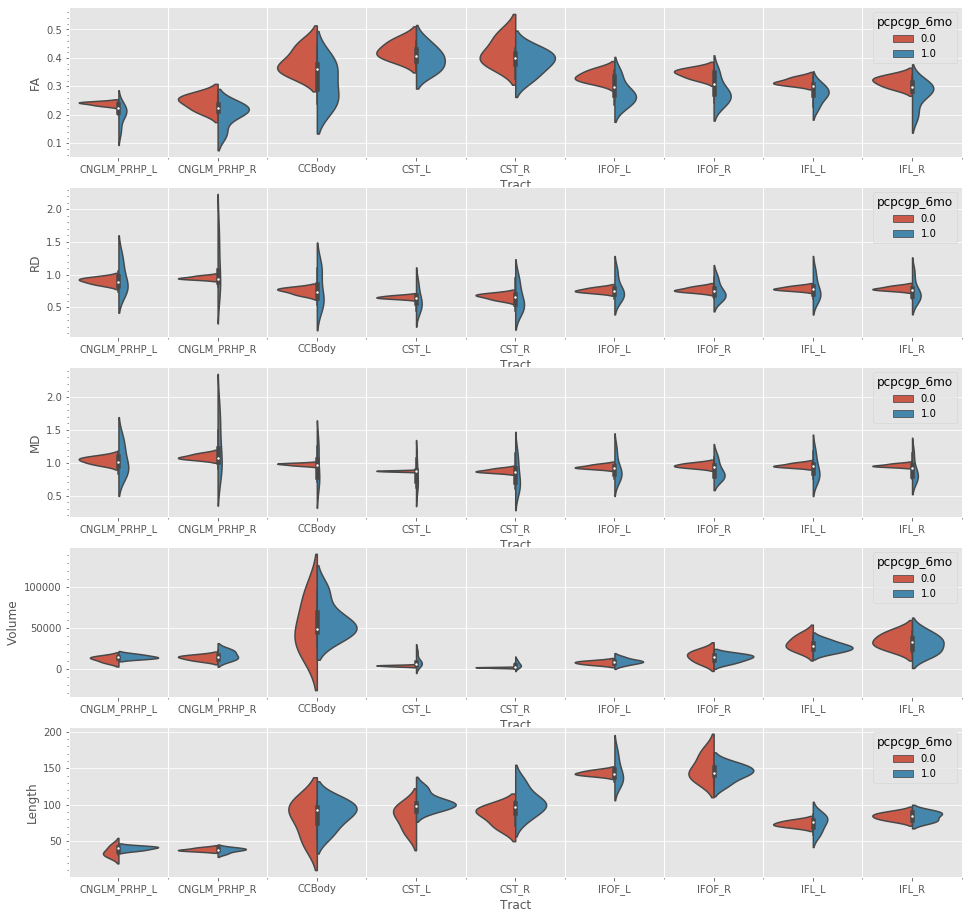

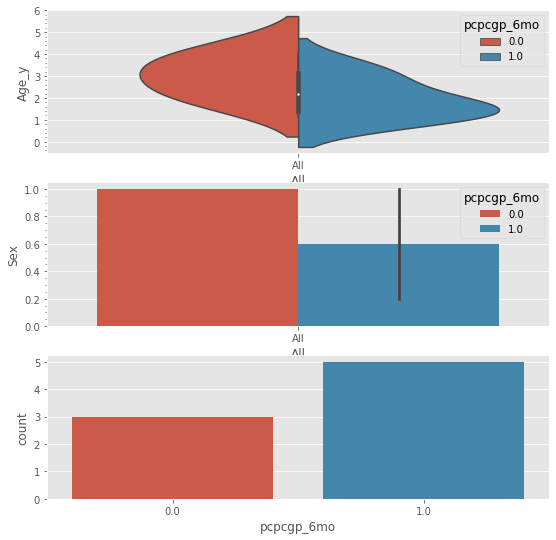

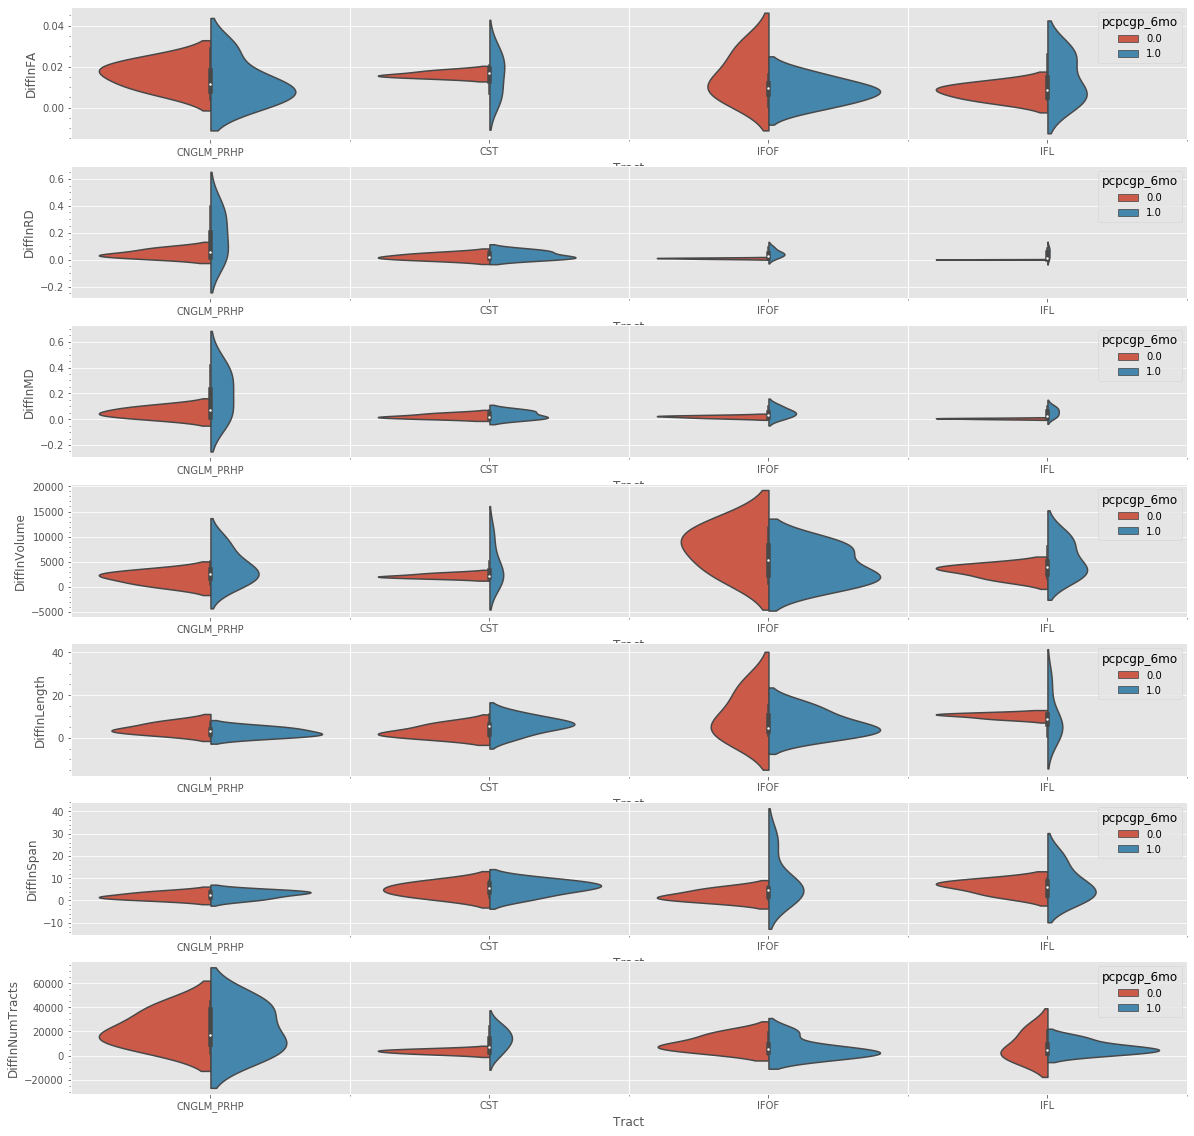

In [40]:
runAnalysis(age1_5_src, age1_5_dir)

In [ ]:
runAnalysis(age5__src, age5__dir)

In [ ]:
runAnalysis(age1__src, age1__dir)

In [ ]:
pdata = getData(all_ages_src) 
fig = plt.figure(figsize =(10, 8))

bp1 = plt.boxplot(pdata['Age_y'])

bp1 = plt.boxplot(pdata['Age_y'])

#bp2 = ax.boxplot()